In [1]:
!pip install noisyopt

In [5]:
import numpy as np
import sklearn
import os
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression
import sklearn
from noisyopt import minimizeCompass
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
#!pip install line_profiler

In [7]:
os.chdir("/content/drive/MyDrive/Winter_Research")

In [ ]:
def load():  
  loadedArr = np.loadtxt("Spacial_Clean.csv", delimiter=',')
  traffic = pd.read_csv("Master_traffic.csv")
  reshape = loadedArr.reshape(49, -1, 5)
  dates = pd.read_csv("Dates_Clean.csv")
  dates = list(dates['2016-07-01'])
  dates.insert(0, '2016-07-01')
  dates_traffic = list(traffic['dates'])
  values_traffic = list(traffic['values'])
  lookup = {}
  for date, val in zip(dates_traffic, values_traffic):
    lookup[date] = val 
  dates_l = dates
  return reshape, dates_l, lookup

In [ ]:
loadedArr = np.loadtxt("Spacial_Img.csv", delimiter=',')

In [ ]:
check = np.loadtxt("Spacial.csv", delimiter=',')

In [ ]:
check[0]

array([2.320000e+03, 1.896000e+03, 1.732000e+03, ..., 1.378000e+03,
       4.075655e+06, 7.013050e+05])

In [ ]:
reshape = loadedArr.reshape(150, -1, 5)

In [ ]:
dates = pd.read_csv("Dates_Clean.csv")
dates = list(dates['2016-07-01'])
dates.insert(0, '2016-07-01')

In [ ]:
print(dates)

['2016-07-01', '2016-07-21', '2016-08-10', '2016-08-30', '2016-09-19', '2016-11-08', '2016-12-18', '2017-06-06', '2017-06-26', '2017-07-11', '2017-07-31', '2017-08-20', '2017-08-25', '2017-10-19', '2017-10-24', '2017-11-13', '2017-11-18', '2017-11-28', '2017-12-03', '2018-02-06', '2018-02-16', '2018-02-21', '2018-03-28', '2018-04-22', '2018-04-27', '2018-05-02', '2018-05-07', '2018-05-12', '2018-05-17', '2018-06-01', '2018-06-11', '2018-06-16', '2018-06-21', '2018-06-26', '2018-07-06', '2018-07-11', '2018-07-16', '2018-07-26', '2018-07-31', '2018-08-05', '2018-08-10', '2018-08-15', '2018-09-04', '2018-09-14', '2018-09-19', '2018-10-09', '2018-10-14', '2018-10-19', '2018-12-13']


In [ ]:
reshape, dates_l, lookup = load()

In [ ]:
reshape_cut = reshape[:, :, :3]

NameError: ignored

In [ ]:
reshape_cut[3]

array([[2220., 1787., 1644.],
       [2124., 1745., 1660.],
       [1554., 1339., 1423.],
       ...,
       [1560., 1355., 1405.],
       [1870., 1616., 1541.],
       [1852., 1618., 1571.]])

In [ ]:
reshape = reshape_cut

In [ ]:
np.unique(reshape, axis=2).shape

(150, 72264, 3)

In [ ]:
for i in range(reshape.shape[0]):
  sum = np.sum(reshape[i], axis=1)
  print(sum[sum != 0].shape)

In [ ]:
rgb_img_test = (255*((dataB4 - 100)/3500)).astype('uint8')

In [ ]:
blue_rat = np.apply_along_axis(lambda x : x[2] / np.sum(x[0]), axis=2, arr=reshape)
green_rat = np.apply_along_axis(lambda x : x[1] / np.sum(x), axis=2, arr=reshape)
red_rat = np.apply_along_axis(lambda x : x[0] / np.sum(x), axis=2, arr=reshape)

In [ ]:
# blue_rat = np.apply_along_axis(lambda x : x[0] - x[1], axis=2, arr=reshape)
# green_rat = np.apply_along_axis(lambda x : x[1] - x[2], axis=2, arr=reshape)
# red_rat = np.apply_along_axis(lambda x : x[2] - x[0], axis=2, arr=reshape)

In [ ]:
reshape.shape

(150, 72264, 3)

In [ ]:
blue_rat.shape

(49, 72264)

In [ ]:
def gather_index():  
  i = 0
  skip_index = []
  regress_val = []
  for date in dates_l:
    if date not in lookup:
      skip_index.append(i)
    else:
      regress_val.append(lookup[date])
    i += 1
  return skip_index, regress_val

In [ ]:
skip_index, regress_val = gather_index()

In [ ]:
skip_index

In [ ]:
test = [13, 31, 40, 44, 69, 73, 83, 99, 107, 116]

In [ ]:
indicies

In [ ]:
indicies = []
data = reshape
def prune(x, train=True):
  counts = []
  vals = []
  lower = 1000*x[0]
  upper = 1000*x[1]
  for i in range(data.shape[0]):
    date = dates_l[i]
    if i in skip_index:
      continue
    row = data[i]
    bright = np.sum(row, axis=1)
    bright_count = bright[bright != 0].shape[0]
    if bright_count < 57724:
      #print("EEEERRROOROROR")
      continue
    if train:
      if i in test:
        continue
    else:
      if i not in test:
        continue
    indicies.append(i)
    bound = row[np.logical_and((bright > lower),(bright < upper))]
    row_red = red_rat[i]
    row_blue = blue_rat[i]
    row_red = row_red[np.logical_and((bright > lower),(bright < upper))]
    row_blue = row_blue[np.logical_and((bright > lower),(bright < upper))]
    bound = bound[np.logical_or((row_blue < x[3]), (row_red > x[2]))]
    if date in lookup:
      counts.append(bound.shape[0] / bright_count)
      vals.append(lookup[date])
  new_x = np.array(counts).reshape(-1,1)
  new_y = np.array(vals)
  fit = LinearRegression().fit(new_x, new_y)
  score = fit.score(new_x, new_y)
  return new_x, new_y, fit
  #return fit
  return 1 - abs(score)

In [ ]:
x0 = np.array([3, 4, 0.3, 0.3])
bounds = [(0,6), (0,6), (0, 1), (0, 1)]
res = minimizeCompass(prune, bounds=bounds, x0=x0, deltatol=0.1, paired=False)

In [ ]:
res

In [ ]:
x, y, fit = prune([3.25, 5.  , 0.3 , 1], train=False)

In [ ]:
x

In [ ]:
#x, y = prune([3.4 , 4.75, 0.75, 0.  ])
#x, y = prune([3.35, 4.85, 0.25, 1])

In [ ]:
fit.coef_

array([-1898.26230322])

In [ ]:
y_pred = fit.predict(x)

In [ ]:
sklearn.metrics.mean_squared_error(y_pred, y)

569063.5038720667

In [ ]:
plt.scatter(x, y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = fit.intercept_ + fit.coef_ * x_vals
plt.plot(x_vals, y_vals, '--')
plt.xlabel("% of Pixels that Meet Thresholds")
plt.ylabel("Traffic")
#plt.savefig("Optimizer_test.png")
plt.show()

NameError: ignored

In [ ]:
data.shape
data_diff = np.zeros(data.shape)
data_diff[:, :, 0] = data[:, :, 1] - data[:, :, 0]
data_diff[:, :, 1] = data[:, :, 2] - data[:, :, 1]
data_diff[:, :, 2] = data[:, :, 0] - data[:, :, 2]

In [ ]:
data_diff

In [ ]:
data_sum = np.sum(data, axis=2)

In [ ]:
data_sum.shape

(150, 72264)

In [ ]:
nnonn_zero = 0
for i in range(data_sum[0]):
  if 

(10839600,)

In [ ]:
skip_index

[13, 14, 15, 17, 23, 121, 122, 123, 124, 125, 131, 132, 133, 143, 145]

In [ ]:
data = reshape

In [ ]:
data = data[:, :, :3]

In [ ]:
data.shape

(49, 72264, 3)

In [ ]:
lengths = []
img_num = 47
pix_num = 72264
channels = 3
cloudless = np.zeros((img_num, pix_num, channels))
red_cl = np.zeros((img_num, pix_num))
green_cl = np.zeros((img_num, pix_num))
blue_cl = np.zeros((img_num, pix_num))
tot_bright = np.zeros((img_num, pix_num))
y = np.zeros(img_num)
max = 72264
index = 0
for i in range(data.shape[0]):
  date = dates_l[i]
  if i in skip_index:
    continue
  row = data[i]
  #print(row)
  bright = np.sum(reshape[i], axis=1)
  #print(bright)
  #bright_count = bright[bright != 0].shape[0]
  #lengths.append(bright_count)
  #print(bright_count)
  #break
  #if bright_count < 72264:
  #  continue
  cloudless[index, :, :] = data[i, :, :]
  red_cl[index, :] = red_rat[i, :]
  blue_cl[index, :] = blue_rat[i, :]
  green_cl[index, :] = green_rat[i, :] 
  tot_bright[index, :] = bright
  y[index] = lookup[date]
  index += 1

In [ ]:
x = np.sum(tot_bright, axis=1)

In [ ]:
red_cl

array([[-588., -328.,  -33., ..., -305., -296., -258.],
       [-642., -542., -300., ..., -241.,   31., -168.],
       [-596., -303.,   -1., ..., -345., -359., -361.],
       ...,
       [-483., -189., -207., ..., -209.,   -8., -300.],
       [-455., -556., -314., ..., -569., -310., -156.],
       [ 298.,  247.,  228., ...,   74.,  185.,  282.]])

In [ ]:
tot_bright

array([[5948., 5350., 4138., ..., 4678., 4383., 4392.],
       [6000., 5769., 4424., ..., 5319., 3950., 4929.],
       [5777., 5239., 4091., ..., 4525., 4436., 4478.],
       ...,
       [5112., 4373., 4299., ..., 4673., 4505., 4839.],
       [4928., 5236., 4592., ..., 5501., 4816., 4224.],
       [3751., 4085., 3933., ..., 4662., 4063., 3862.]])

In [ ]:
cloudless[0]

array([[-424., -164.,  588.],
       [-328.,    0.,  328.],
       [-140.,  107.,   33.],
       ...,
       [-279.,  -26.,  305.],
       [-265.,  -31.,  296.],
       [-258.,    0.,  258.]])

In [ ]:
std_r = np.std(red_cl, axis=1)
std_g = np.std(green_cl, axis=1)
std_b = np.std(blue_cl, axis=1)

In [ ]:
x = np.array([std_r, std_g, std_b]).reshape(-1, 3)

In [ ]:
y.shape

(47,)

In [ ]:
new_x = x.reshape(-1, 1)
new_y = np.array(y)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)

In [ ]:
score

0.09889197181030684

In [ ]:
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = fit.intercept_ + fit.coef_ * x_vals
plt.plot(x_vals, y_vals, '--')
plt.xlabel("Green % stdv")
plt.ylabel("Traffic count")
plt.savefig("Green_r.png")

In [ ]:
score

0.040375002772502167

In [ ]:
# plt.plot(range(len(lengths)), sorted(lengths))
# plt.ylabel("# of Pixels")
# plt.title("Number of pixels per image")
# plt.savefig("Num_pix.png")

In [ ]:
lengths

In [ ]:
feat_num = 1200
features = np.zeros((img_num, feat_num))

In [ ]:
splices = [x/20 for x in range(21)]
r_e = scipy.stats.mstats.mquantiles(red_cl, prob=splices)
b_e = scipy.stats.mstats.mquantiles(blue_cl, prob=splices)
g_e = scipy.stats.mstats.mquantiles(green_cl, prob=splices)
bright_e = scipy.stats.mstats.mquantiles(tot_bright, prob=splices)

In [ ]:
np.count_nonzero(b_e)

21

In [ ]:
cloudless

In [ ]:
for i in range(cloudless.shape[0]):
  row = []
  cloud_row = cloudless[i]
  red_row = red_cl[i]
  green_row = green_cl[i]
  blue_row = blue_cl[i]
  bright_row = tot_bright[i]
  for j in range(len(splices) - 1):
    l_b = bright_e[j]
    h_b = bright_e[j + 1]
    for k in range(len(splices) - 1):
      red_temp = red_row[np.logical_and((bright_row > l_b), (bright_row < h_b))]
      green_temp = green_row[np.logical_and((bright_row > l_b), (bright_row < h_b))]
      blue_temp = green_row[np.logical_and((bright_row > l_b), (bright_row < h_b))]
      red_count = np.count_nonzero(red_temp[np.logical_and((red_temp > r_e[k]), (red_temp < r_e[k+1]))])
      blue_count = np.count_nonzero(blue_temp[np.logical_and((blue_temp > b_e[k]), (blue_temp < b_e[k+1]))])
      green_count = np.count_nonzero(green_temp[np.logical_and((green_temp > g_e[k]), (green_temp < g_e[k+1]))])
      row.extend([red_count, green_count, blue_count])
  features[i, :] = np.array(row)


In [ ]:
features

In [ ]:
cloudless_new = np.sort(cloudless, axis=1).reshape(150, -1, 1).squeeze()
#train_x, train_y = cloudless[:38], y[:38]
#test_x, test_y = cloudless[38:], y[38:]

In [ ]:
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')


1


In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, y, test_size=0.2, random_state=41)
X_train = torch.as_tensor(X_train, device=cuda0, dtype=torch.float)
X_test = torch.as_tensor(X_test, device=cuda0, dtype=torch.float)
y_train = torch.as_tensor(y_train, device=cuda0, dtype=torch.float)
y_test = torch.as_tensor(y_test, device=cuda0, dtype=torch.float)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [ ]:
print(X_test.shape, y_test.shape)

torch.Size([10, 1200]) torch.Size([10, 1])


# PyTorch Model

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features=1200, out_features=500)
    self.fc2 = nn.Linear(in_features=500, out_features=50)
    self.fc3 = nn.Linear(in_features=50, out_features=10)
    self.output = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.output(x)
    return x
model = Net()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
X_train.shape

torch.Size([37, 1200])

In [ ]:
batches_x = [X_train[:10], X_train[10:20], X_train[20:30], X_train[30:]]
batches_y = [y_train[:10], y_train[10:20], y_train[20:30], y_train[30:]]

In [ ]:
del optimizer
del criterion
torch.cuda.empty_cache()


In [ ]:
criterion = nn.MSELoss()
model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
train_loss = []
test_loss = []

In [ ]:
X_train[0]

tensor([0.0000e+00, 3.3000e+01, 2.0300e+02,  ..., 1.0000e+00, 7.1110e+03,
        0.0000e+00], device='cuda:0')

In [ ]:
epochs = 1
loss_arr = []
for i in range(epochs):
  loss_tot = 0
  #for j in range(X_train.shape[0]):
  for batch_x, batch_y in zip(batches_x, batches_y):  
    y_hat = model.forward(batch_x)
  #print("y_hat", y_hat.shape, y_hat)
  #print("y_train", y_train)
  #break
    loss = criterion(y_hat, batch_y)
    loss_arr.append(loss)
    loss_tot += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if i % 1 == 0:
    print(f'Epoch: {i} Loss: {loss_tot // 4}')
    train_loss.append(int(loss_tot // 4))

Epoch: 0 Loss: 328530.0


In [ ]:
preds = []
with torch.no_grad():
  y_hat_t = model.forward(X_test)
  loss = criterion(y_hat_t, y_test)
  test_loss.append(loss.item())
  print(loss.item())
  #preds.append(y_hat.argmax().item())

448698.90625


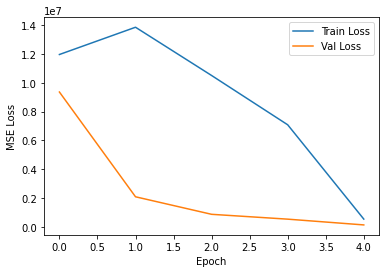

In [ ]:
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(test_loss)), test_loss)
plt.legend(["Train Loss", "Val Loss"])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
#plt.savefig("Train_Test.png")
plt.show()

In [ ]:
test_loss = test_loss*10

In [ ]:
y_test_mean = torch.Tensor([2425]*10).reshape(10, 1)

In [ ]:
y_test_mean

In [ ]:
y_hat_t

In [ ]:
l = criterion(y_test.cpu()[3], y_test_mean[3])

In [ ]:
l

tensor(555025.)

0.5530717981146016


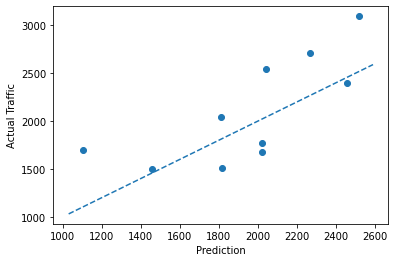

In [ ]:
x_temp = y_test.cpu()
y_temp = y_hat_t.cpu()
x_plot = np.array(y_temp)
y_plot = np.array(x_temp)
new_x = np.array(x_plot).reshape(-1,1)
new_y = np.array(y_plot)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)
plt.xlabel("Prediction")
plt.ylabel("Actual Traffic")
print(score)
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')
#plt.savefig("Updated_CRS_pred.png")
plt.show()

In [ ]:
X_test

In [ ]:
y_hat

In [ ]:
torch.cuda.memory_summary(device=0, abbreviated=False)

In [ ]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass